In [1]:
import tensorflow as tf
import collections
import tensorflow_federated as tff

import numpy as np
from jedi.debug import speed
from sklearn.metrics import label_ranking_average_precision_score

2025-12-09 09:33:25.023772: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-09 09:33:25.442823: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-09 09:33:25.442846: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-09 09:33:25.442861: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-09 09:33:25.447350: I tensorflow/core/platform/cpu_feature_g

In [2]:
import tensorflow.keras.backend as K
import gc

K.clear_session()  # Clear TF session to free GPU memory
gc.collect()

5

In [3]:
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.14.1


2025-12-09 09:33:31.917723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-09 09:33:32.421812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-09 09:33:32.423637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
)

kidney_dataset = datagen.flow_from_directory(
    '/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer',
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    batch_size=32,
)

Found 10000 images belonging to 2 classes.


Batch shape: (32, 224, 224, 3)
Single image shape: (224, 224, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Label [0. 1.]


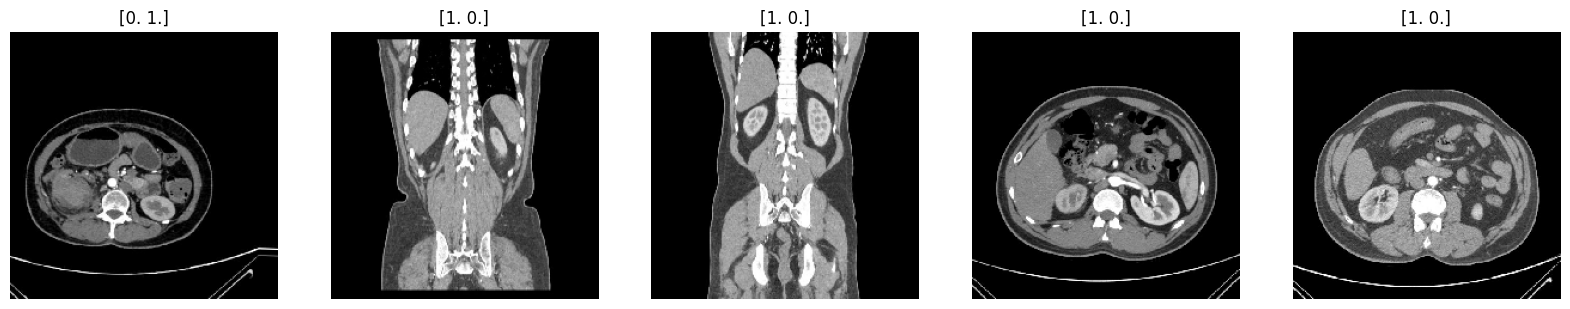

In [5]:
import matplotlib.pyplot as plt
images, labels = next(kidney_dataset)
for i in range(1):
    print("Batch shape:", images.shape)
    print("Single image shape:", images[0].shape)
    print("Min pixel value:", images.min())
    print("Max pixel value:", images.max())
    print("Label", labels[0])

fig, ax = plt.subplots(1, 5, figsize=(20,5))
for i in range(5):
    ax[i].imshow(images[i])
    ax[i].set_title(labels[i])
    ax[i].axis('off')

plt.show()


In [6]:
type(kidney_dataset)

keras.src.preprocessing.image.DirectoryIterator

In [7]:
import os

data_dir = '/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer'
class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
class_labels = {name: idx for idx, name in enumerate(class_names)}

print(class_labels)

image_paths = []
labels = []
for class_name in class_names:
    path1 = os.path.join(data_dir, class_name)
    print(path1)
    paths = os.listdir(path1)
    for path in paths:
        image_paths.append(os.path.join(path1, path))
        labels.append(class_labels[class_name])

print(image_paths[1])

{'kidney_normal': 0, 'kidney_tumor': 1}
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_normal
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_tumor
/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer/kidney_normal/kidney_normal_0403.jpg


In [8]:
NUM_MALICIOUS = 3
FLIP_PROB = 0.4

In [9]:
import os
import random

class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
class_labels = {name: idx for idx, name in enumerate(class_names)}

def load_image(path, img_size=(224, 224)):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img

def create_client_dataset(image_paths, label, img_size=(224, 224), flip=False, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42):
    images = []
    labels = []
    target_size=(64, 64)
    for i, path in enumerate(image_paths):
        img = load_image(path, img_size)
        img = tf.image.resize(img, target_size)
        images.append(img)
        labels.append(label[i])

    labels = np.array(labels, dtype=np.int32)
    if flip:
        rng = np.random.RandomState(seed)
        num_classes = len(np.unique(labels))
        n = len(labels)

        # randomly choose which samples to flip
        mask = rng.rand(n) < float(flip_prob)

        if mask.sum() > 0:
            rand_targets = rng.randint(0, num_classes, size=n)
            # ensure flipped label != original label
            rand_targets[rand_targets == labels] = (rand_targets[rand_targets == labels] + 1) % num_classes
            labels[mask] = rand_targets[mask]

    print(f"{len(images)}  {len(labels)}   malicious_client={flip}")
    ds = tf.data.Dataset.from_tensor_slices((images, labels.tolist()))
    ds = ds.shuffle(buffer_size=len(images)).batch(8)
    return ds


def prepare_client_dataset(data_dir, num_client, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42):
    image_paths = []
    labels = []

    class_names = os.listdir('/home/mahesh/Desktop/Dissertation/Fed_tf_cancer/data/Multi Cancer/Multi Cancer/Kidney Cancer')
    class_labels = {name: idx for idx, name in enumerate(class_names)}
    print(class_labels)

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        paths = os.listdir(class_path)
        for path in paths:
            image_paths.append(os.path.join(class_path, path))
            labels.append(class_labels[class_name])

    #image_paths = image_paths[:4000]
    combined = list(zip(image_paths, labels))
    rng = random.Random(seed)
    rng.shuffle(combined)

    combined = combined[:4000]
    image_paths, labels = zip(*combined)

    malicious_clients = []

    all_client_ids = [f"client_{i}" for i in range(num_client)]
    if num_malicious > 0:
        num_malicious = min(num_malicious, num_client)
        malicious_clients = rng.sample(all_client_ids, k=num_malicious)
    print("Malicious clients selected:", malicious_clients)

    clients_datasets = {}
    total_images = len(image_paths)
    for i in range(num_client):
        client_id = "client_{}".format(i)
        start = i * total_images // num_client
        end = ((i + 1) * total_images) // num_client
        print(client_id, start, end)
        do_flip = client_id in malicious_clients
        clients_datasets[client_id] = create_client_dataset(image_paths[start:end], labels[start:end], flip=do_flip, img_size=(224, 224), num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42)

    return clients_datasets


client_datasets = prepare_client_dataset(data_dir=data_dir, num_client=10, num_malicious = NUM_MALICIOUS, flip_prob = FLIP_PROB, seed = 42)

{'kidney_normal': 0, 'kidney_tumor': 1}
Malicious clients selected: ['client_9', 'client_1', 'client_8']
client_0 0 400


2025-12-09 09:33:33.396518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-09 09:33:33.397494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-09 09:33:33.398643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

400  400   malicious_client=False
client_1 400 800
400  400   malicious_client=True
client_2 800 1200
400  400   malicious_client=False
client_3 1200 1600
400  400   malicious_client=False
client_4 1600 2000
400  400   malicious_client=False
client_5 2000 2400
400  400   malicious_client=False
client_6 2400 2800
400  400   malicious_client=False
client_7 2800 3200
400  400   malicious_client=False
client_8 3200 3600
400  400   malicious_client=True
client_9 3600 4000
400  400   malicious_client=True


In [10]:
client_datasets

{'client_0': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_1': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_2': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_3': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_4': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_5': <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'client_6': <_B

In [11]:
class_labels

{'kidney_normal': 0, 'kidney_tumor': 1}

In [12]:
type(client_datasets['client_0'])

tensorflow.python.data.ops.batch_op._BatchDataset

Client: client_0


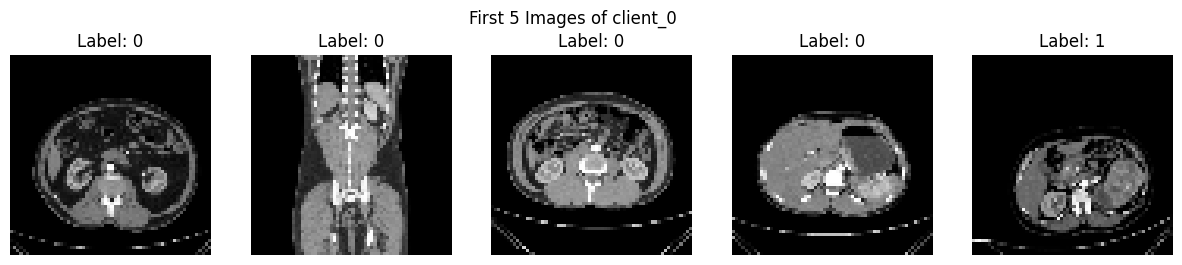

Client: client_1


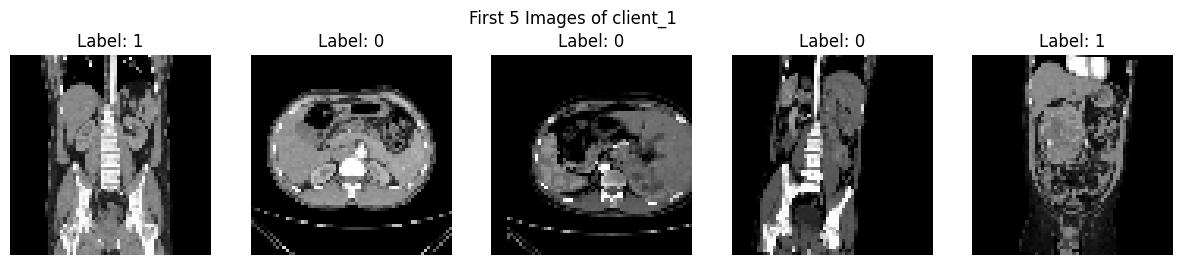

Client: client_2


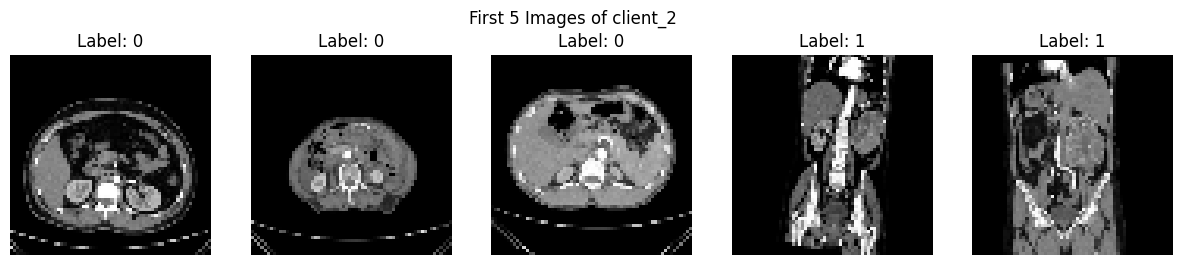

Client: client_3


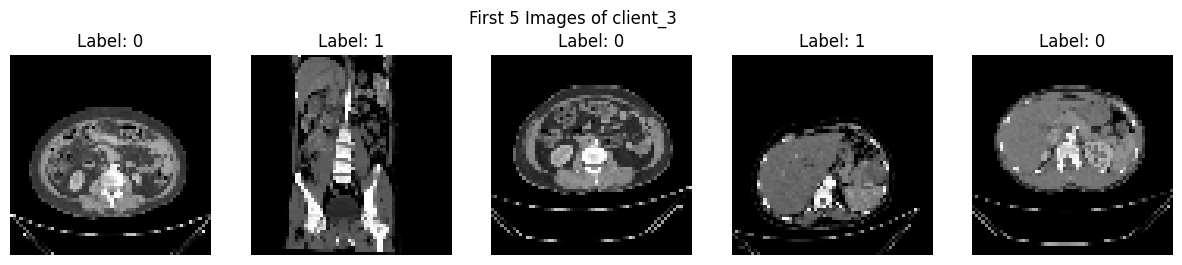

Client: client_4


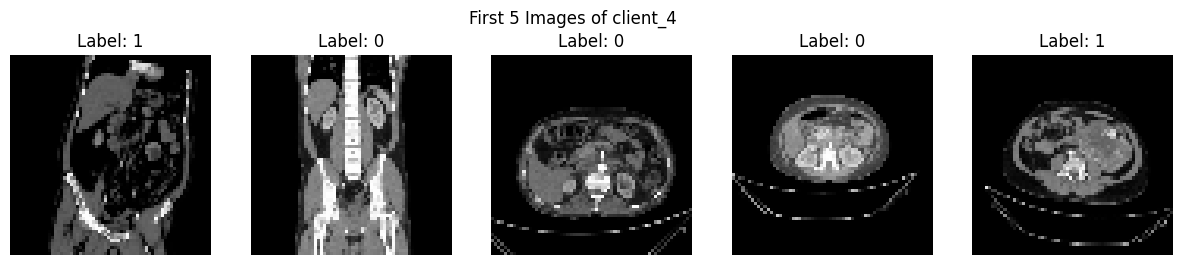

Client: client_5


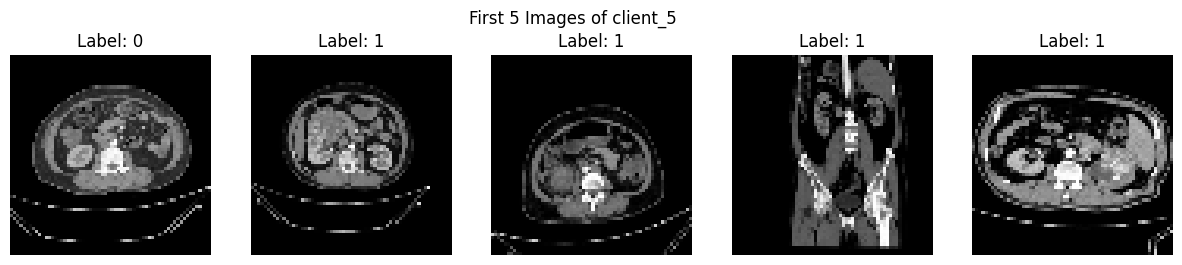

Client: client_6


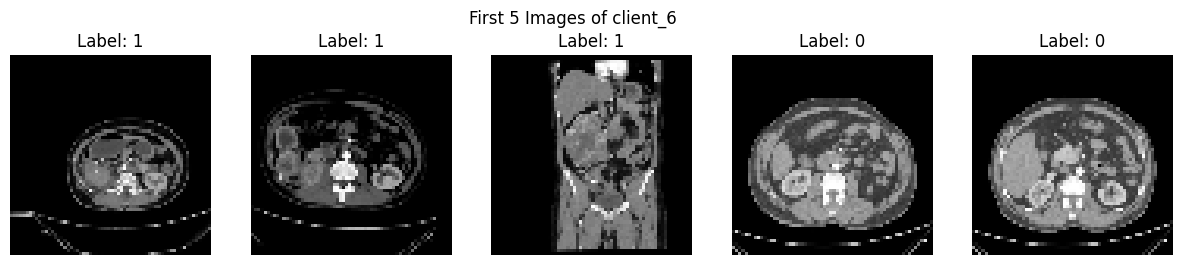

Client: client_7


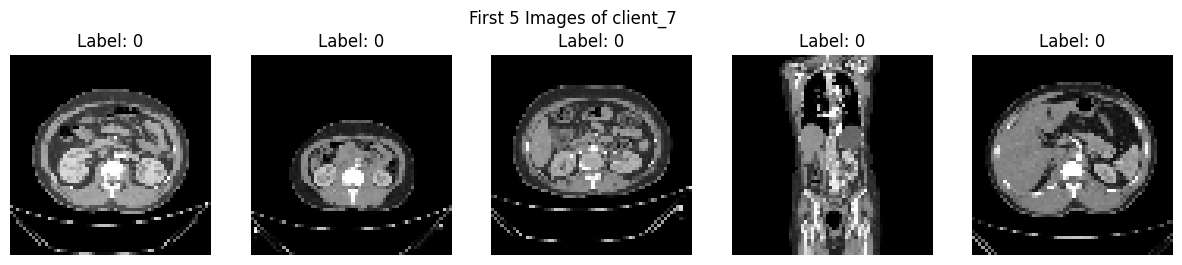

Client: client_8


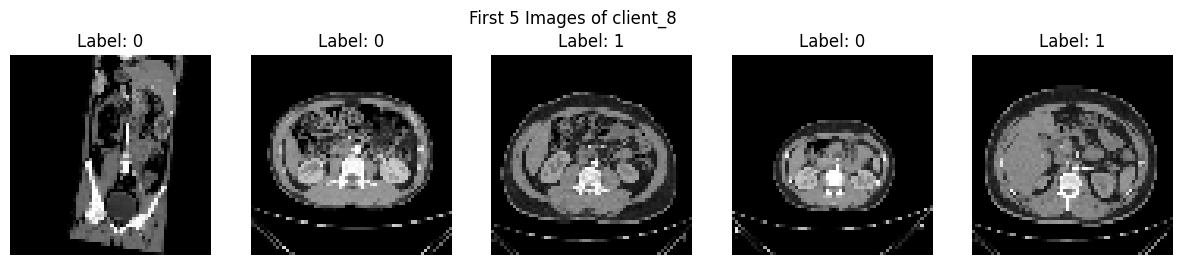

Client: client_9


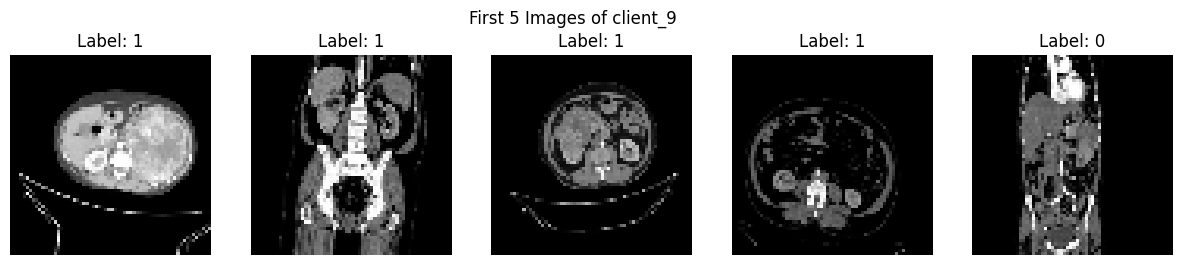

In [13]:
import matplotlib.pyplot as plt

def show_images_with_labels(images, labels, title=None):
    plt.figure(figsize=(15, 3))
    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

def print_first_5_images_with_labels(clients_datasets):
    for client_id, dataset in clients_datasets.items():
        print(f"Client: {client_id}")

        images_collected = []
        labels_collected = []
        for batch_images, batch_labels in dataset.take(1):
            images_slice = batch_images[:5]
            labels_slice = batch_labels[:5]
            batch_np_images = images_slice.numpy()
            batch_np_labels = labels_slice.numpy()
            for img, lbl in zip(batch_np_images, batch_np_labels):
                images_collected.append(img)
                labels_collected.append(lbl)

        show_images_with_labels(images_collected, labels_collected, title=f"First 5 Images of {client_id}")


print_first_5_images_with_labels(client_datasets)


In [14]:
for images, labels in client_datasets['client_0'].take(1):
    print(images.shape)
    print(labels.shape)
    print(labels)

(8, 64, 64, 3)
(8,)
tf.Tensor([0 1 1 0 1 1 1 0], shape=(8,), dtype=int32)


In [15]:
## Creating the basic model
def create_keras_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')  # For 2-class classification
    ])
    return model


In [16]:
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=client_datasets['client_0'].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

In [17]:
sample_model = create_keras_model()

sample_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # for one-hot or multi-class
    metrics=['accuracy']
)

In [18]:
sample_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

In [19]:
with tf.device('/GPU:0'):
    sample_model.fit(client_datasets['client_0'], epochs=5, verbose=2)

Epoch 1/5


2025-12-09 09:33:45.301880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-12-09 09:33:46.320424: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x780c902b56a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-09 09:33:46.320459: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-12-09 09:33:46.326162: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-09 09:33:46.399009: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 - 3s - loss: 0.5836 - accuracy: 0.7250 - 3s/epoch - 54ms/step
Epoch 2/5
50/50 - 0s - loss: 0.3848 - accuracy: 0.8275 - 218ms/epoch - 4ms/step
Epoch 3/5
50/50 - 0s - loss: 0.2070 - accuracy: 0.9150 - 122ms/epoch - 2ms/step
Epoch 4/5
50/50 - 0s - loss: 0.0670 - accuracy: 0.9825 - 188ms/epoch - 4ms/step
Epoch 5/5
50/50 - 0s - loss: 0.0814 - accuracy: 0.9675 - 164ms/epoch - 3ms/step


In [20]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.02),
    server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1.0),
)

In [21]:
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[3,3,3,32],
      float32[32],
      float32[3,3,32,64],
      float32[64],
      float32[3,3,64,128],
      float32[128],
      float32[4608,128],
      float32[128],
      float32[128,2],
      float32[2]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<
    learning_rate=float32
  >,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    learning_rate=float32
  >
>@SERVER)


In [22]:
train_state = training_process.initialize()

2025-12-09 09:33:50.146934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-09 09:33:50.147944: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-12-09 09:33:50.147996: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-12-09 09:33:50.148238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-09 09:33:50.149148: I tensorflow/compiler/xla/stream_executor/

In [23]:
client_datasets_list = [client_datasets[key] for key in sorted(client_datasets.keys())]
client_datasets_list = list(client_datasets.values())

In [24]:
import importlib
serialization_utils = importlib.import_module('tensorflow_federated.python.program.serialization_utils')
print(serialization_utils._MAX_SERIALIZED_DATASET_SIZE)
##serialization_utils._MAX_SERIALIZED_DATASET_SIZE = 1073741824

262144000


In [25]:
print(tff.__file__)

/home/mahesh/miniconda3/envs/tf_fed/lib/python3.9/site-packages/tensorflow_federated/__init__.py


In [26]:
train_accuracies = []
train_losses = []
train_state_data = []
NUM_ROUNDS = 30

for round_num in range(1, NUM_ROUNDS):
  result = training_process.next(train_state, client_datasets_list)
  train_state = result.state
  train_state_data.append(train_state)
  metrics = result.metrics
  print('round {:2d}, metrics={}'.format(round_num, metrics))
  try:
        acc = metrics['client_work']['train']['sparse_categorical_accuracy']
        loss = metrics['client_work']['train']['loss']
  except KeyError:
        print(f"Available metric keys at round {round_num}: {metrics.keys()}")
        acc, loss = None, None

  train_accuracies.append(acc)
  train_losses.append(loss)
  print(f"Round {round_num}: accuracy={acc:.4f}, loss={loss:.4f}")

2025-12-09 09:33:51.829110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-09 09:33:51.830107: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-12-09 09:33:51.830169: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-12-09 09:33:51.830420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-09 09:33:51.831337: I tensorflow/compiler/xla/stream_executor/

round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.54), ('loss', 0.68977755), ('num_examples', 4000), ('num_batches', 500)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 1: accuracy=0.5400, loss=0.6898
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.5955), ('loss', 0.6761803), ('num_examples', 4000), ('num_batches', 500)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2: accuracy=0.5955, loss=0.6762
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.60825), ('loss', 0.66094005), ('num_examples', 4000), ('num_batches', 500)]))])), ('aggregato

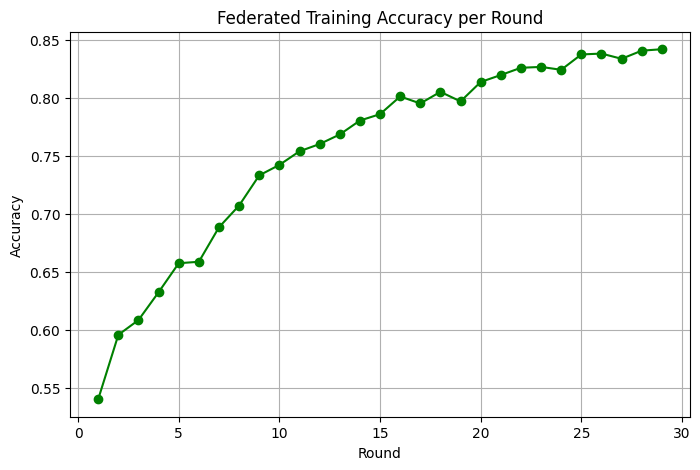

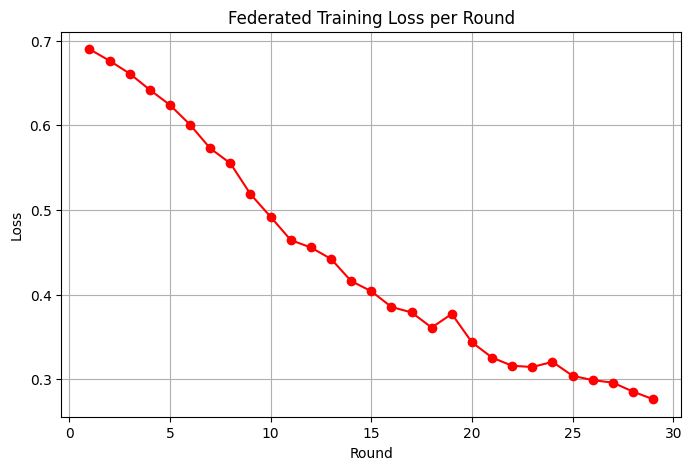

In [27]:
plt.figure(figsize=(8,5))
plt.plot(range(1, NUM_ROUNDS), train_accuracies, color='green', marker='o')
plt.title('Federated Training Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, NUM_ROUNDS), train_losses, color='red', marker='o')
plt.title('Federated Training Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [32]:
len(train_state_data)

29

In [28]:
train_state_data[0]

LearningAlgorithmState(global_model_weights=ModelWeights(trainable=[array([[[[-7.61305392e-02, -6.20940030e-02,  5.86828701e-02,
           5.14376909e-02,  4.76920716e-02, -5.09378128e-02,
          -5.19210696e-02,  1.28778741e-01, -8.25575888e-02,
           2.44537089e-02,  9.46331471e-02,  5.19719794e-02,
          -7.15733618e-02, -1.02539018e-01, -1.20349608e-01,
           4.85259742e-02, -1.02548152e-01, -3.24974619e-02,
           6.95361272e-02, -3.93173173e-02,  2.61591766e-02,
          -1.29679263e-01, -1.25580698e-01, -1.27480194e-01,
          -1.30730063e-01, -8.01517442e-03,  4.00686525e-02,
           5.14543019e-02, -9.62071270e-02,  1.26682624e-01,
           4.59782556e-02,  6.58620745e-02],
         [ 1.24894992e-01,  1.78417028e-03, -7.87253827e-02,
          -1.28104448e-01,  2.52987705e-02,  5.81358410e-02,
          -2.51257326e-02,  2.66102049e-03,  9.68547165e-02,
           9.77835804e-02, -7.00033754e-02,  6.06281981e-02,
          -1.30952805e-01,  2.082

In [29]:
train_state_data[0][0][0]

[array([[[[-7.61305392e-02, -6.20940030e-02,  5.86828701e-02,
            5.14376909e-02,  4.76920716e-02, -5.09378128e-02,
           -5.19210696e-02,  1.28778741e-01, -8.25575888e-02,
            2.44537089e-02,  9.46331471e-02,  5.19719794e-02,
           -7.15733618e-02, -1.02539018e-01, -1.20349608e-01,
            4.85259742e-02, -1.02548152e-01, -3.24974619e-02,
            6.95361272e-02, -3.93173173e-02,  2.61591766e-02,
           -1.29679263e-01, -1.25580698e-01, -1.27480194e-01,
           -1.30730063e-01, -8.01517442e-03,  4.00686525e-02,
            5.14543019e-02, -9.62071270e-02,  1.26682624e-01,
            4.59782556e-02,  6.58620745e-02],
          [ 1.24894992e-01,  1.78417028e-03, -7.87253827e-02,
           -1.28104448e-01,  2.52987705e-02,  5.81358410e-02,
           -2.51257326e-02,  2.66102049e-03,  9.68547165e-02,
            9.77835804e-02, -7.00033754e-02,  6.06281981e-02,
           -1.30952805e-01,  2.08206698e-02,  1.24909647e-01,
            1.02976561e-

In [30]:
x = train_state_data[0][0][0]
(rows, cols) = (len(x), len(x[0]))
print(rows, cols)

10 3


In [31]:
def list_shape(lst):
    shape = []
    while isinstance(lst, list):
        shape.append(len(lst))
        lst = lst[0] if len(lst) > 0 else []
    return tuple(shape)

list_shape(train_state_data[0][0][0])

(10,)